# Intro to DLC2Action (mini)

DLC2Action is a package for automatic behavior prediction. It offers implementation of SOTA models and keeps track of experiments.

To see how it works, we will experiment on a relatively small [publically available](https://github.com/ETHZ-INS/DLCAnalyzer/tree/master/data/OFT) dataset (Sturman, 2020). Run the code below to download the data.

This is a minimalistic version of this notebook, check out demo_notebook.ipynb for more information.

In [ ]:
!pip install gdown
!gdown https://drive.google.com/uc?id=1BhAAy_YYxWXYVSpCmYXIAOEV9waoMwcK
!apt-get install unzip
!unzip OFT.zip -d OFT

Downloading...
From: https://drive.google.com/uc?id=1BhAAy_YYxWXYVSpCmYXIAOEV9waoMwcK
To: /home/liza/DLC2Action_minimal/examples/OFT.zip
100%|█████████████████████████████████████████| 475M/475M [00:04<00:00, 111MB/s]
E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?
Archive:  OFT.zip
   creating: OFT/OFT/
  inflating: OFT/__MACOSX/._OFT      
  inflating: OFT/OFT/.DS_Store       
  inflating: OFT/__MACOSX/OFT/._.DS_Store  
   creating: OFT/OFT/Labels/
   creating: OFT/OFT/Output_DLC/
  inflating: OFT/OFT/Labels/23_02_A_190507135734.csv  
  inflating: OFT/OFT/Labels/12_01_A_190507144429.csv  
  inflating: OFT/OFT/Labels/53_04_A_190507135800.csv  
  inflating: OFT/OFT/Labels/43_03_A_190507151557.csv  
  inflating: OFT/OFT/Labels/57_04_A_190507150030.csv  
  inflating: OFT/OFT/Labels/25_02_A_190507142904.csv  
  inflating: OFT/OFT/Labels/AllLabDataOFT_final.csv  


... installation

for now:
```
git clone https://github.com/AlexEMG/DLC2Action
cd DLC2Action
conda create --name DLC2Action python=3.9
conda activate DLC2Action
python -m pip install .
```

In [1]:
from dlc2action.project import Project
import os

# CURRENT_PATH = os.getcwd()
# DATA_PATH = os.path.join(CURRENT_PATH, "OFT", "OFT", "Output_DLC")
# LABELS_PATH = os.path.join(CURRENT_PATH, "OFT", "OFT", "Labels")
# PROJECTS_PATH = os.path.join(CURRENT_PATH, "DLC2Action")

DATA_PATH = "/home/liza/OFT/Output_DLC"
LABELS_PATH = "/home/liza/OFT/Labels"
PROJECTS_PATH = "/home/liza/DLC2Action_tmp"

High-level methods in DLC2Action are almost exclusively accessed through the `dlc2action.project.Project` class. A project instance should loosely correspond to a specific goal (e.g. generating automatic annotations for dataset A with input format X). You can use it to optimize hyperparameters, run experiments, analyze results and generate new data.

**Best practices**
- When you need to do something with a different data type or unrelated files, it's better to create a new project to keep the experiment history easy to understand.
- Each project is associated with a folder on your computer that contains all settings, meta files and experiment outputs. Those folders are created in the folder at `projects_path`. It's generally a good idea to choose one and stick to it throughout projects.

### Creating a project

Let's begin!

We will create a project called `"oft"`, with `"dlc_track"` input and `"csv"` annotation format. 

You can run `Project.print_data_types()` and `Project.print_annotation_types()` to find out more about other options.

In [2]:
# Project.remove_project("oft", projects_path=PROJECTS_PATH)
project = Project(
    "oft",
    data_path=DATA_PATH,
    annotation_path=LABELS_PATH,
    projects_path=PROJECTS_PATH,
    data_type="dlc_track",
    annotation_type="csv",
)

## Setting parameters

After the project is created, it's time to configure the parameter settings. 

The first step is to check which essential parameters are missing with `project.list_blanks()`.

In [3]:
project.list_blanks()

Before running experiments, please update all the blanks.
To do that, you can run this.
--------------------------------------------------------
project.update_parameters(
    {
        "data": {
            "data_suffix": ..., # set; the data files should have the format of {video_id}{data_suffix}, e.g. video1_suffix.pickle, where video1 is the video is and _suffix.pickle is the suffix
            "canvas_shape": ..., # list; the size of the canvas where the pose was defined
            "annotation_suffix": ..., # str | set, optional the suffix or the set of suffices such that the annotation files are named {video_id}{annotation_suffix}, e.g, video1_suffix.pickle where video1 is the video id and _suffix.pickle is the suffix
        },
        "general": {
            "exclusive": ..., # bool; if true, single-label classification is used; otherwise multi-label
        },
    }
)
--------------------------------------------------------
Replace ... with relevant values.


We can copy this code, fill in the blanks and run it. 

We will also set the number of epochs here. Normally the default should be fine but for the purpose of this tutorial we want to set it smaller so that our experiments can finish in time.

In [6]:
project.update_parameters(
    {
        "data": {
            "data_suffix": "DeepCut_resnet50_Blockcourse1May9shuffle1_1030000.csv", # set; the data files should have the format of {video_id}{data_suffix}, e.g. video1_suffix.pickle, where video1 is the video is and _suffix.pickle is the suffix
            "canvas_shape": [928, 576], # list; the size of the canvas where the pose was defined
            "annotation_suffix": ".csv", # str | set, optional the suffix or the set of suffices such that the annotation files are named {video_id}{annotation_suffix}, e.g, video1_suffix.pickle where video1 is the video id and _suffix.pickle is the suffix
        },
        "general": {
            "exclusive": True, # bool; if true, single-label classification is used; otherwise multi-label
        },
        "training": {
            "num_epochs": 15,
        }
    }
)

Now we're all set and can start training models.

## Hyperparameter search

There are many hyperparameters in model training, like the number of layers in a model or loss coefficients. The default settings for those parameters should generate reasonable results on most datasets but in order to get the most out of our data we can run a hyperparameter search.

The easiest way to find a good set of hyperparameters for your data is to run `project.run_default_hyperparameter_search()`.

In [7]:
project.run_default_hyperparameter_search(
    "test_search",
    num_epochs=10,
    n_trials=5,
)

[I 2022-11-17 01:51:49,027] A new study created in memory with name: no-name-ad3a9caa-529d-41a4-9670-93bc80c333d9


SEARCH test_search
Computing input features...


100%|██████████| 20/20 [00:09<00:00,  2.16it/s]


Computing annotation arrays...


100%|██████████| 20/20 [00:00<00:00, 271.61it/s]


Filtering 93.33% of samples
Number of samples:
    validation:
      {-100: 4026, 1: 60, 4: 10, 2: 0, 3: 0, 0: 0}
    training:
      {-100: 16104, 1: 148, 3: 97, 4: 35, 2: 0, 0: 0}
    test:
      {1: 0, 2: 0, 3: 0, 4: 0, 0: 0}
Computing normalization statistics...


100%|██████████| 16/16 [00:00<00:00, 417.99it/s]

Initializing class weights:
    160000000.0, 0.108, 160000000.0, 0.165, 0.457
Behavior indices:
    0: other
    1: Grooming
    2: StartEnd
    3: Supported
    4: Unsupported


[epoch 1]: loss 0.1863, f1 0.101
validation: loss 0.1596, f1 0.050
[epoch 2]: loss 0.1490, f1 0.305
validation: loss 0.1592, f1 0.054
[epoch 3]: loss 0.1168, f1 0.353
validation: loss 0.1591, f1 0.066
[epoch 4]: loss 0.0773, f1 0.429
validation: loss 0.1593, f1 0.050
[epoch 5]: loss 0.0474, f1 0.495
validation: loss 0.1603, f1 0.057
[epoch 6]: loss 0.0278, f1 0.570
validation: loss 0.1591, f1 0.050
[epoch 7]: loss 0.0248, f1 0.533
validation: loss 0.1581, f1 0.051
[epoch 8]: loss 0.0264, f1 0.556
validation: loss 0.1577, f1 0.051
[epoch 9]: loss 0.0158, f1 0.561
validation: loss 0.1573, f1 0.061


[I 2022-11-17 01:52:07,549] Trial 0 finished with value: 0.06861116364598274 and parameters: {'losses/ms_tcn/alpha': 3.17178623560126e-05, 'losses/ms_tcn/focal': True, 'training/temporal_subsampling_size': 0.9905673856009127, 'model/num_f_maps': 98, 'general/len_segment': 1024}. Best is trial 0 with value: 0.06861116364598274.


[epoch 10]: loss 0.0114, f1 0.557
validation: loss 0.1556, f1 0.080
Number of samples:
    validation:
      {-100: 4026, 1: 60, 4: 10, 2: 0, 3: 0, 0: 0}
    training:
      {-100: 16104, 1: 148, 3: 97, 4: 35, 2: 0, 0: 0}
    test:
      {1: 0, 2: 0, 3: 0, 4: 0, 0: 0}
Computing normalization statistics...


100%|██████████| 16/16 [00:00<00:00, 470.83it/s]


Initializing class weights:
    160000000.0, 0.108, 160000000.0, 0.165, 0.457
Behavior indices:
    0: other
    1: Grooming
    2: StartEnd
    3: Supported
    4: Unsupported
[epoch 1]: loss 1.6740, f1 0.109
validation: loss 1.6035, f1 0.000
[epoch 2]: loss 1.5568, f1 0.278
validation: loss 1.5995, f1 0.077
[epoch 3]: loss 1.4673, f1 0.395
validation: loss 1.5951, f1 0.103
[epoch 4]: loss 1.3630, f1 0.394
validation: loss 1.5909, f1 0.087
[epoch 5]: loss 1.2268, f1 0.462
validation: loss 1.5855, f1 0.067
[epoch 6]: loss 1.0599, f1 0.487
validation: loss 1.5804, f1 0.044
[epoch 7]: loss 0.9296, f1 0.499
validation: loss 1.5753, f1 0.047
[epoch 8]: loss 0.7455, f1 0.526
validation: loss 1.5723, f1 0.058
[epoch 9]: loss 0.5915, f1 0.551
validation: loss 1.5725, f1 0.070


[I 2022-11-17 01:52:09,439] Trial 1 finished with value: 0.08901361127694447 and parameters: {'losses/ms_tcn/alpha': 0.0015675461757992998, 'losses/ms_tcn/focal': False, 'training/temporal_subsampling_size': 0.9418813019061888, 'model/num_f_maps': 47, 'general/len_segment': 1024}. Best is trial 1 with value: 0.08901361127694447.


[epoch 10]: loss 0.4611, f1 0.547
validation: loss 1.5725, f1 0.055
Computing input features...


100%|██████████| 20/20 [00:09<00:00,  2.07it/s]


Computing annotation arrays...


100%|██████████| 20/20 [00:00<00:00, 267.49it/s]


Filtering 95.17% of samples
Number of samples:
    validation:
      {-100: 2490, 1: 60, 4: 10, 2: 0, 3: 0, 0: 0}
    training:
      {-100: 12008, 1: 148, 3: 97, 4: 35, 2: 0, 0: 0}
    test:
      {1: 0, 2: 0, 3: 0, 4: 0, 0: 0}
Computing normalization statistics...


100%|██████████| 24/24 [00:00<00:00, 540.21it/s]

Initializing class weights:
    240000000.0, 0.162, 240000000.0, 0.247, 0.686
Behavior indices:
    0: other
    1: Grooming
    2: StartEnd
    3: Supported
    4: Unsupported


[epoch 1]: loss 1.6263, f1 0.094
validation: loss 1.6126, f1 0.052
[epoch 2]: loss 1.4921, f1 0.254
validation: loss 1.6087, f1 0.051
[epoch 3]: loss 1.3362, f1 0.406
validation: loss 1.6034, f1 0.051
[epoch 4]: loss 1.2166, f1 0.375
validation: loss 1.5954, f1 0.051
[epoch 5]: loss 1.0024, f1 0.422
validation: loss 1.5868, f1 0.050
[epoch 6]: loss 0.7671, f1 0.483
validation: loss 1.5785, f1 0.050
[epoch 7]: loss 0.5575, f1 0.529
validation: loss 1.5707, f1 0.050
[epoch 8]: loss 0.3715, f1 0.553
validation: loss 1.5597, f1 0.050
[epoch 9]: loss 0.2863, f1 0.568
validation: loss 1.5552, f1 0.050
[epoch 10]: loss 0.2065, f1 0.571
validation: loss 1.5399, f1 0.050


[I 2022-11-17 01:52:22,206] Trial 2 finished with value: 0.051392332961161934 and parameters: {'losses/ms_tcn/alpha': 2.1880757674834135e-05, 'losses/ms_tcn/focal': False, 'training/temporal_subsampling_size': 0.8809482811075158, 'model/num_f_maps': 70, 'general/len_segment': 512}. Best is trial 1 with value: 0.08901361127694447.


Number of samples:
    validation:
      {-100: 4026, 1: 60, 4: 10, 2: 0, 3: 0, 0: 0}
    training:
      {-100: 16104, 1: 148, 3: 97, 4: 35, 2: 0, 0: 0}
    test:
      {1: 0, 2: 0, 3: 0, 4: 0, 0: 0}
Computing normalization statistics...


100%|██████████| 16/16 [00:00<00:00, 350.56it/s]


Initializing class weights:
    160000000.0, 0.108, 160000000.0, 0.165, 0.457
Behavior indices:
    0: other
    1: Grooming
    2: StartEnd
    3: Supported
    4: Unsupported
[epoch 1]: loss 0.1737, f1 0.157
validation: loss 0.1629, f1 0.000
[epoch 2]: loss 0.1427, f1 0.282
validation: loss 0.1615, f1 0.056


[I 2022-11-17 01:52:23,022] Trial 3 pruned. 


Initializing class weights:
    160000000.0, 0.108, 160000000.0, 0.165, 0.457
Behavior indices:
    0: other
    1: Grooming
    2: StartEnd
    3: Supported
    4: Unsupported
[epoch 1]: loss 1.6151, f1 0.126
validation: loss 1.6218, f1 0.000
[epoch 2]: loss 1.5291, f1 0.227
validation: loss 1.6209, f1 0.000


[I 2022-11-17 01:52:23,801] Trial 4 pruned. 


best parameters: {'losses/ms_tcn/alpha': 0.0015675461757992998, 'losses/ms_tcn/focal': False, 'training/temporal_subsampling_size': 0.9418813019061888, 'model/num_f_maps': 47, 'general/len_segment': 1024}




{'losses/ms_tcn/alpha': 0.0015675461757992998,
 'losses/ms_tcn/focal': False,
 'training/temporal_subsampling_size': 0.9418813019061888,
 'model/num_f_maps': 47,
 'general/len_segment': 1024}

## Training models

Now we can train models with the best hyperparameters.

In [8]:
project.run_episode(
    "test_best",
    load_search="test_search", # loading the search
    force=True, # when force=True, if an episode with this name already exists it will be overwritten -> use with caution!
)

TRAINING test_best
Computing input features...


100%|██████████| 20/20 [00:09<00:00,  2.06it/s]


Computing annotation arrays...


100%|██████████| 20/20 [00:00<00:00, 338.41it/s]


Filtering 96.00% of samples
Number of samples:
    validation:
      {-100: 9081, 1: 115, 4: 20, 2: 0, 3: 0, 0: 0}
    training:
      {-100: 39342, 1: 294, 3: 220, 4: 80, 2: 0, 0: 0}
    test:
      {1: 0, 2: 0, 3: 0, 4: 0, 0: 0}
Computing normalization statistics...


100%|██████████| 39/39 [00:00<00:00, 535.19it/s]

Initializing class weights:
    390000000.0, 0.133, 390000000.0, 0.177, 0.487
Behavior indices:
    0: other
    1: Grooming
    2: StartEnd
    3: Supported
    4: Unsupported


[epoch 1]: loss 1.6629, f1 0.104, precision 0.139, recall 0.124
validation: loss 1.6028, f1 0.052, precision 0.030, recall 0.200
[epoch 2]: loss 1.5686, f1 0.206, precision 0.337, recall 0.284
validation: loss 1.6023, f1 0.052, precision 0.030, recall 0.200
[epoch 3]: loss 1.4257, f1 0.309, precision 0.402, recall 0.380
validation: loss 1.6005, f1 0.077, precision 0.231, recall 0.212
[epoch 4]: loss 1.2815, f1 0.387, precision 0.423, recall 0.442
validation: loss 1.5985, f1 0.084, precision 0.232, recall 0.216
[epoch 5]: loss 1.1400, f1 0.438, precision 0.451, recall 0.486
validation: loss 1.5968, f1 0.106, precision 0.234, recall 0.228
[epoch 6]: loss 0.9817, f1 0.470, precision 0.469, recall 0.509
validation: loss 1.5957, f1 0.116, precision 0.240, recall 0.228
[epoch 7]: loss 0.8205, f1 0.504, precision 0.494, recall 0.536
validation: loss 1.5968, f1 0.147, precision 0.270, recall 0.224
[epoch 8]: loss 0.6813, f1 0.536, precision 0.524, recall 0.557
validation: loss 1.5994, f1 0.107

## Evaluation

Now that we've trained our best models, we can analyze the results.

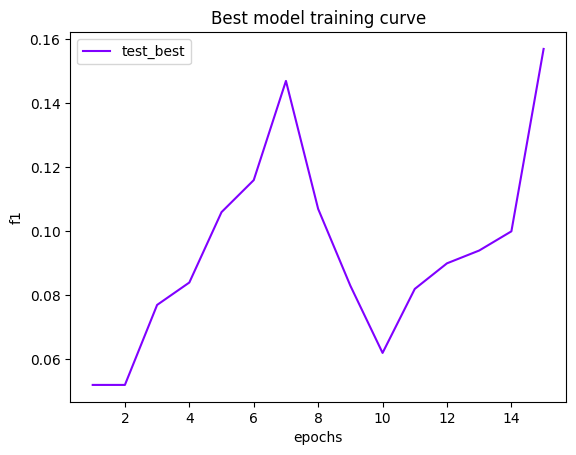

In [9]:
project.plot_episodes(
    ["test_best"],
    metrics=["f1"], # F1 score
    title="Best model training curve"
)

We can also check out more metrics now. See `project.help("metrics")` to see other options.

In [11]:
project.evaluate(
    ["test_best"],
    parameters_update={
        "general": {"metric_functions": ["segmental_f1", "mAP", "f1"]},
        "metrics": {
            "f1": {"average": "none"}
        }
    }
)

EVALUATION test_best
episode test_best
Number of samples:
    validation:
      {-100: 9081, 1: 115, 4: 20, 2: 0, 3: 0, 0: 0}
    training:
      {-100: 39342, 1: 294, 3: 220, 4: 80, 2: 0, 0: 0}
    test:
      {1: 0, 2: 0, 3: 0, 4: 0, 0: 0}
Setting loaded normalization statistics...
Initializing class weights:
    390000000.0, 0.133, 390000000.0, 0.177, 0.487
Behavior indices:
    0: other
    1: Grooming
    2: StartEnd
    3: Supported
    4: Unsupported


100%|██████████| 1/1 [00:00<00:00, 16.89it/s]



AGGREGATED:


f1_0 0.000, f1_1 0.083, f1_2 0.000, f1_3 0.000, f1_4 0.702, mAP 0.000, segmental_f1 0.000
Inference time: 0:00:00




{'segmental_f1': 0.0,
 'mAP': 0.0,
 'f1_0': 0.0,
 'f1_1': 0.0833333283662796,
 'f1_2': 0.0,
 'f1_3': 0.0,
 'f1_4': 0.7017543315887451}

## Using trained models

When you find that you are happy with the results, you can use the model to generate predictions for new data. 

Predictions here are probabilities of each behavior being seen in each frame while suggestions are suggested intervals generated from those probabilities.

Let's generate a prediction with one of our models and look at one of the resulting files. Note that you can use multiple models and average over their predictions.

In [12]:
project.run_prediction(
    "test_best_prediction",
    episode_names=[f"test_best"],
    force=True
)

PREDICTION test_best_prediction
episode test_best
Computing input features...


100%|██████████| 20/20 [00:10<00:00,  1.86it/s]


Computing annotation arrays...


100%|██████████| 20/20 [00:00<00:00, 540.92it/s]


Filtering 96.00% of samples
Number of samples:
    validation:
      {1: 0, 2: 0, 3: 0, 4: 0, 0: 0}
    training:
      {-100: 48423, 1: 409, 3: 220, 4: 100, 2: 0, 0: 0}
    test:
      {1: 0, 2: 0, 3: 0, 4: 0, 0: 0}
Setting loaded normalization statistics...
Initializing class weights:
    480000000.0, 0.117, 480000000.0, 0.218, 0.48
Behavior indices:
    0: other
    1: Grooming
    2: StartEnd
    3: Supported
    4: Unsupported


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]

In [15]:
import pickle
import os


# picking a random file from the prediction folder
prediction_folder = project.prediction_path("test_best_prediction")
prediction_file = os.listdir(prediction_folder)[0]
prediction_file = os.path.join(prediction_folder, prediction_file)

with open(prediction_file, "rb") as f: # open the file
    prediction = pickle.load(f)

for key, value in prediction.items(): # explore the contents
    if key not in ["max_frames", "min_frames", "video_tag", "behaviors"]:
        print(f'{key}: {value.shape}')
    
behaviors_order = prediction["behaviors"]

start = 50
end = 70
action = "Unsupported"

index = behaviors_order.index(action)

print(f'The mean probability of {action} between frames {start} and {end} is {prediction["ind0"][index, start: end].mean()}')

ind0: torch.Size([5, 15227])
The mean probability of Unsupported between frames 50 and 70 is 0.18226733803749084


We will now remove unnecessary data to clean the memory.

In [16]:
project.remove_saved_features()
project.remove_extra_checkpoints()

Removing datasets...


100%|██████████| 4/4 [00:00<00:00, 91.26it/s]